In [1]:
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
dataframe = pd.read_csv("SP500DATA.csv")
print(dataframe)# Text file data converted to integer data type
Shillerdataframe = pd.read_csv("S&P500 Schiller PE ratio.csv")
print(Shillerdataframe)

           Date    Price     Open     High      Low Vol.  Change %
0    01/12/2021  4766.18  4623.80  4808.52  4494.20    -    0.0436
1    01/11/2021  4567.00  4616.47  4743.74  4560.26    -   -0.0083
2    01/10/2021  4605.38  4324.71  4608.70  4278.70    -    0.0691
3    01/09/2021  4307.54  4531.04  4544.58  4304.90    -   -0.0476
4    01/08/2021  4522.68  4415.90  4537.80  4369.20    -    0.0290
..          ...      ...      ...      ...      ...  ...       ...
618  01/06/1970    72.72    76.55    79.96    72.25    -   -0.0500
619  01/05/1970    76.55    81.52    82.32    68.61    -   -0.0610
620  01/04/1970    81.52    89.63    90.70    79.31    -   -0.0905
621  01/03/1970    89.63    89.50    91.07    86.19    -    0.0015
622  01/02/1970    89.50    85.02    90.33    84.64    -    0.0527

[623 rows x 7 columns]
                 DateTime  SP500PERatio
0     1871-01-01 00:00:58         11.10
1     1871-02-01 00:00:58         11.25
2     1871-03-01 00:00:58         11.52
3     1871-0

# Step 1

In [2]:
trainData = dataframe[["Price", "Open"]].to_numpy(dtype = 'float')
targetData = dataframe[["Price"]].to_numpy(dtype = 'float')
date = dataframe[["Date"]].to_numpy(dtype = "str")

norm = MinMaxScaler(feature_range = (0, 1))
trainData = norm.fit_transform(trainData)
targetData = norm.fit_transform(targetData)
trainData = np.flip(trainData)
targetData = np.flip(targetData)
date = np.flip(date)

dateAxis = []
for i in range(date.shape[0]):
    dateAxis.append(float(np.squeeze(date)[i][6:10]) + float(np.squeeze(date)[i][3:5])/12.0)
dateAxis = np.array(dateAxis)
dateAxis_test=date[438:623,:]
dateAxis = dateAxis[6:620]
print(dateAxis.shape)

(614,)


In [3]:
X = []
Y = []
for i in range(trainData.shape[0] - 5 - 4):
    X.append(trainData[i:i+6])
    Y.append(targetData[i+6:i+6+4])
X = np.array(X)
Y = np.array(Y)
Y = np.swapaxes(Y, 1, 2)
Y.shape

(614, 1, 4)

In [4]:
X_fullTraining = []
X_training = []
X_validation = []
X_test = []
Y_fullTraining = []
Y_training = []
Y_validation = []
Y_test = []

X_fullTraining, X_test, Y_fullTraining, Y_test, date_ft, date_t = train_test_split(X, Y, dateAxis, test_size=0.3, shuffle=False)
X_training, X_validation, Y_training, Y_validation, date_tr, date_v = train_test_split(X_fullTraining, Y_fullTraining, date_ft, test_size=0.3, shuffle=False)

date_test=date[438:623,:]

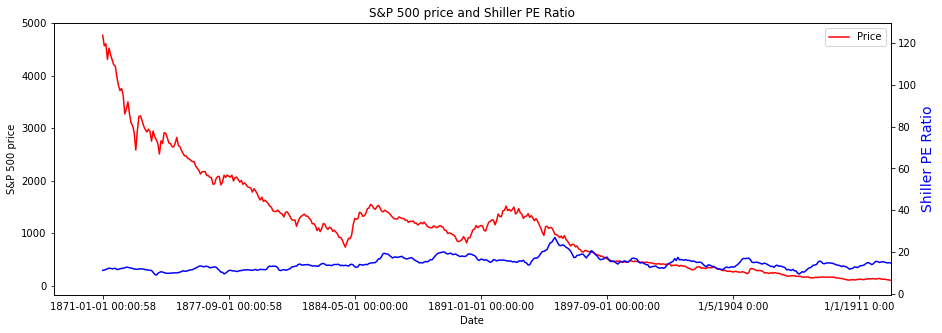

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(dataframe.Date, dataframe.Price, color='red', label='Price')
#plt.plot(dataframe.Date, dataframe.Open.values, color='grey', label='Open')
# plt.plot(dataframe.Date, dataframe.Close.values, color='black', label='Close')
#plt.plot(dataframe.Date, dataframe.Low.values, color='red', label='Low')
#plt.plot(dataframe.Date, dataframe.High.values, color='green', label='High')
plt.title('S&P 500 price and Shiller PE Ratio')
plt.xlabel('Date')
plt.ylabel('S&P 500 price')
plt.legend(loc='best')
# twin object for two different y-axis on the sample plot
ax2=plt.twinx()
ax2.set_xticks(ax2.get_xticks()[::80])
plt.xlim(-31.1,500.1)
# make a plot with different y-axis using second axis object
ax2.plot(Shillerdataframe.DateTime, Shillerdataframe.SP500PERatio.values,color="blue")
ax2.set_ylabel("Shiller PE Ratio", color="blue",fontsize=14)
plt.show()

# Step 2

In [6]:
class Model(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers):
        super(Model, self).__init__()

        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)   

        self.fc = nn.Linear(hidden_dim, output_size)
    
    def forward(self, x):
        
        batch_size = x.size(0)

        hidden = self.init_hidden(batch_size)

        out, hidden = self.rnn(x, hidden)
    
        out = self.fc(out)
    
        return out[:, -1, :], hidden
    
    def init_hidden(self, batch_size):
        hidden = torch.zeros(self.n_layers, batch_size, self.hidden_dim)
        return hidden

In [7]:
RNN = Model(input_size=2, output_size=4, hidden_dim=16, n_layers=1)
optimizer = torch.optim.Adam(RNN.parameters(), lr=0.01)
criterion = nn.MSELoss()
RNN

Model(
  (rnn): RNN(2, 16, batch_first=True)
  (fc): Linear(in_features=16, out_features=4, bias=True)
)

# Step 3

In [8]:
xTensor = torch.from_numpy(X_fullTraining).float()
yTensor = torch.Tensor(Y_fullTraining).float()

for epoch in range(100):
    optimizer.zero_grad()
    
    output, hidden = RNN(xTensor)
    loss = criterion(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizer.step()
    
    if epoch%10 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 100), end=' ')
        print("Loss:", loss.item())

Epoch: 0/100............. Loss: 0.1062178686261177
Epoch: 10/100............. Loss: 0.00950424000620842
Epoch: 20/100............. Loss: 0.006924233864992857
Epoch: 30/100............. Loss: 0.005472407676279545
Epoch: 40/100............. Loss: 0.0021004851441830397
Epoch: 50/100............. Loss: 0.0005024292040616274
Epoch: 60/100............. Loss: 0.00022582567180506885
Epoch: 70/100............. Loss: 0.0001892605796456337
Epoch: 80/100............. Loss: 0.00010538773494772613
Epoch: 90/100............. Loss: 0.00010320870933355764


In [9]:
def prediction_error(pred, actual):
    return abs(pred - actual)/pred

In [10]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_fullTrainingplt = norm.inverse_transform(Y_fullTraining[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.051036  0.047496  1.483688  2.422809
2 day  0.042479  0.036760  1.947672  6.376822
3 day  0.082139  0.063809  0.826661  0.272570
4 day  0.084887  0.062243  0.896014  0.793382

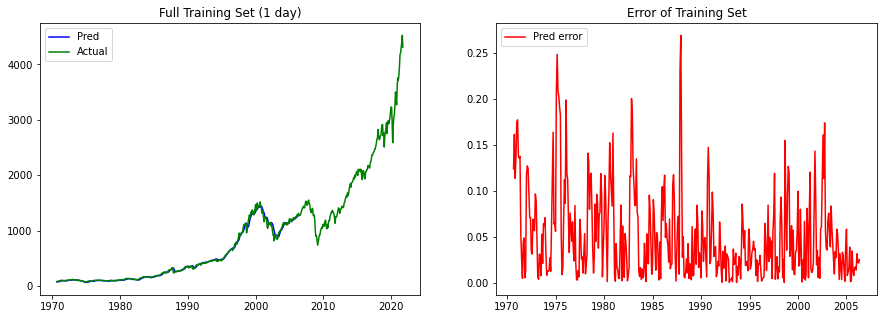

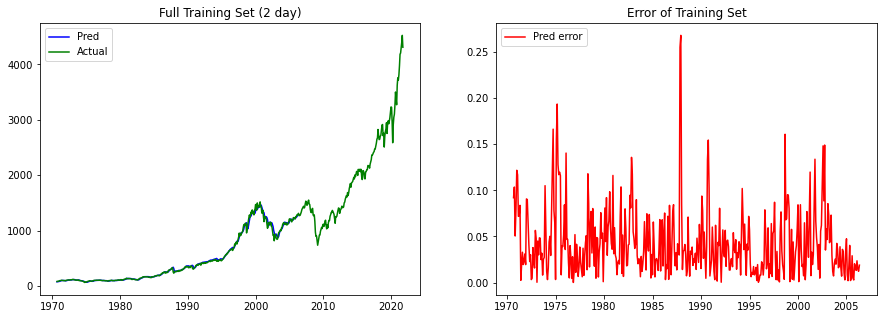

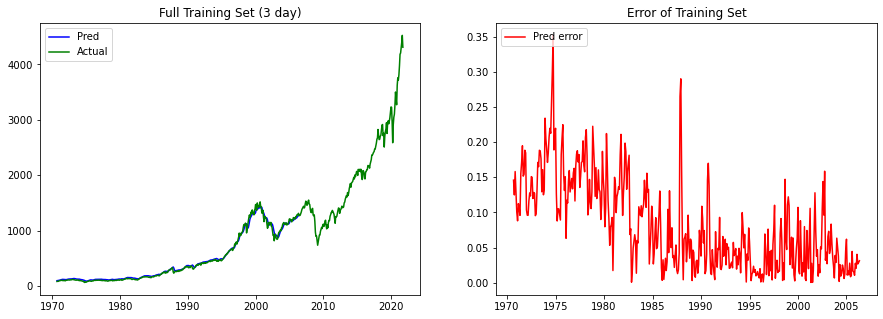

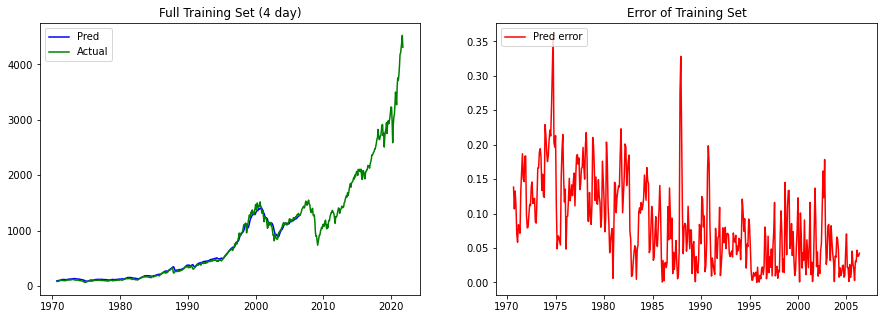

In [11]:
table = []

error = prediction_error(output_plt1, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (1 day)")
ax1.plot(date_ft, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (2 day)")
ax1.plot(date_ft, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (3 day)")
ax1.plot(date_ft, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_fullTrainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Full Training Set (4 day)")
ax1.plot(date_ft, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_ft, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 4 

In [12]:
RNN.eval()
xTensor = torch.from_numpy(X_test).float()
output, _ = RNN(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.136784  0.129653  1.668455  2.614827
2 day  0.109467  0.096193  1.368195  1.420744
3 day  0.130862  0.117739  1.537928  2.098268
4 day  0.173773  0.154843  1.442044  1.744058

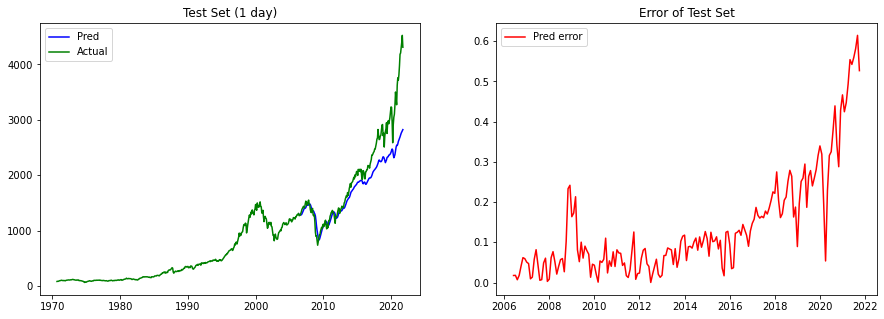

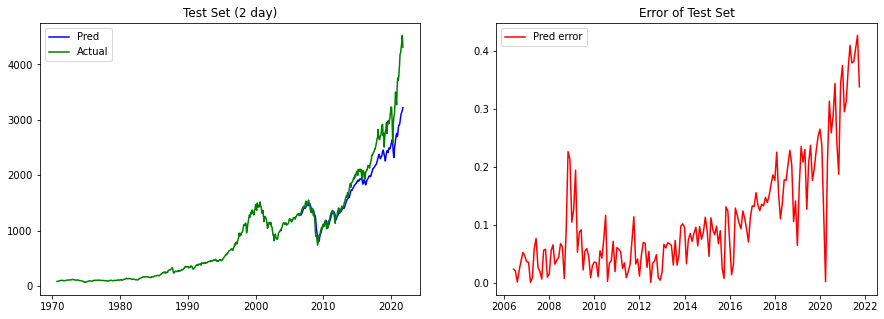

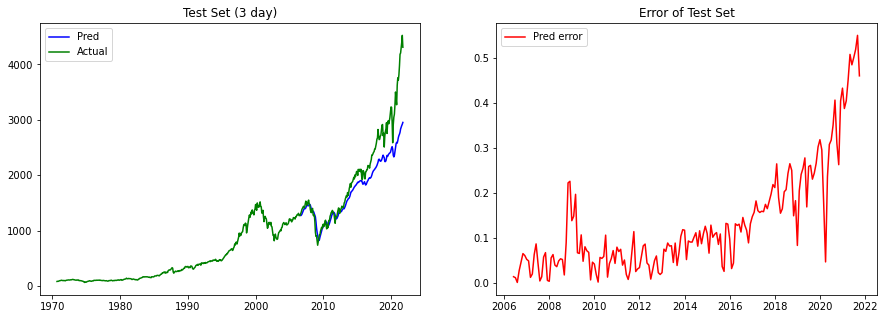

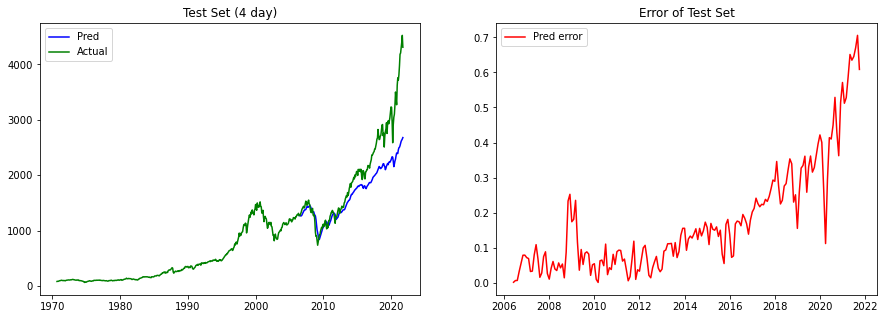

In [13]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)
    
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)
                  
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 5

In [14]:
RNNval = Model(input_size=2, output_size=4, hidden_dim=32, n_layers=2)
optimizerVal = torch.optim.Adam(RNNval.parameters(), lr=0.002)
criterionVal = nn.MSELoss()
RNNval

xTensor = torch.from_numpy(X_training).float()
yTensor = torch.Tensor(Y_training).float()

for epoch in range(200):
    optimizerVal.zero_grad()
    
    output, hidden = RNNval(xTensor)
    loss = criterionVal(output.reshape(-1), yTensor.view(-1))
    loss.backward()
    
    optimizerVal.step()
    
    if epoch%100 == 0:
        print('Epoch: {}/{}.............'.format(epoch, 200), end=' ')
        print("Loss:", loss.item())

Epoch: 0/200............. Loss: 0.04718393459916115
Epoch: 100/200............. Loss: 5.557770055020228e-05


In [15]:
output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_plt = norm.inverse_transform(Y[:, :, 0])
Y_trainingplt = norm.inverse_transform(Y_training[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.051997  0.043721  1.583598  4.277336
2 day  0.051818  0.043182  1.689676  4.860937
3 day  0.050301  0.041547  1.876699  6.198783
4 day  0.052284  0.041919  1.862496  6.064659

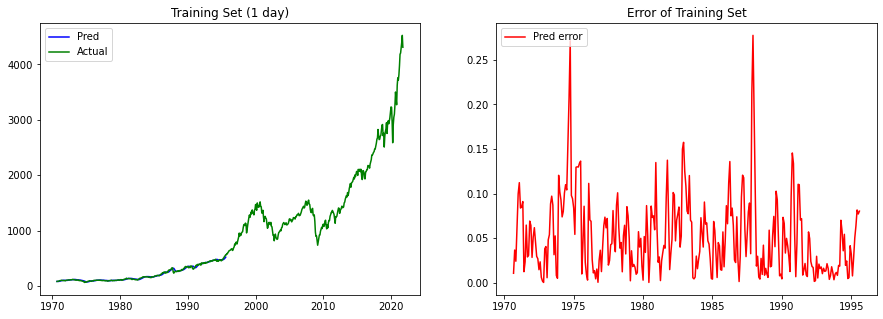

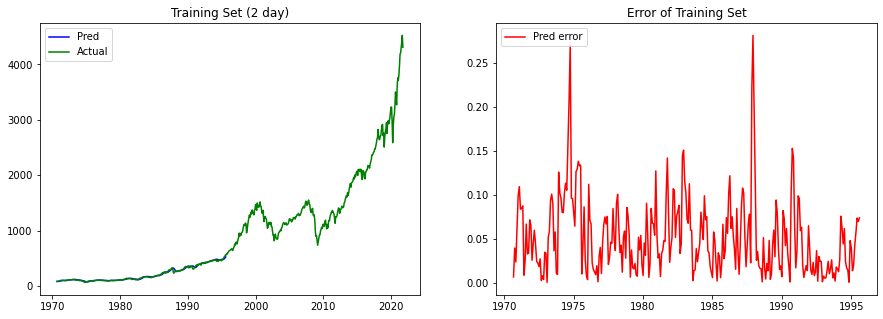

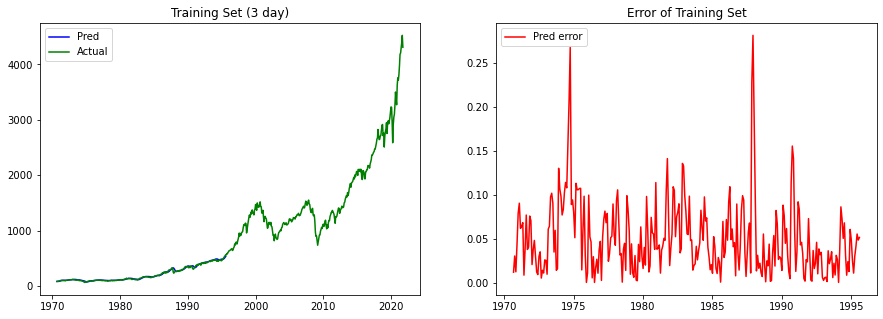

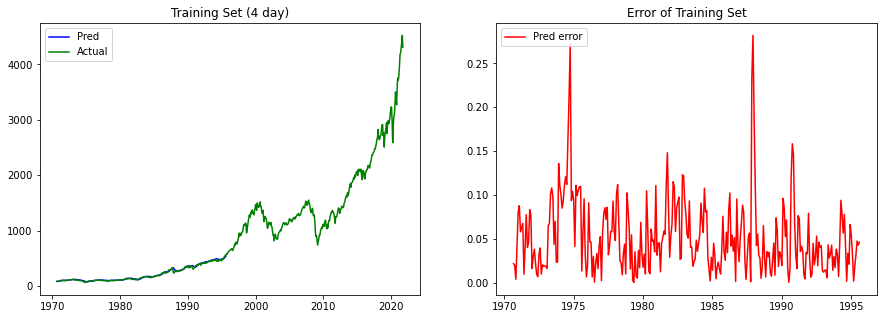

In [16]:
table = []

error = prediction_error(output_plt1, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (1 day)")
ax1.plot(date_tr, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (2 day)")
ax1.plot(date_tr, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (3 day)")
ax1.plot(date_tr, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_trainingplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Training Set (4 day)")
ax1.plot(date_tr, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Training Set")
ax2.plot(date_tr, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [17]:
RNNval.eval()
xTensor = torch.from_numpy(X_validation).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_validationplt = norm.inverse_transform(Y_validation[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.073277  0.041542  0.704707  0.165473
2 day  0.085034  0.046644  0.526501 -0.041408
3 day  0.051291  0.037880  1.100419  0.995270
4 day  0.048283  0.038208  1.173528  1.284037

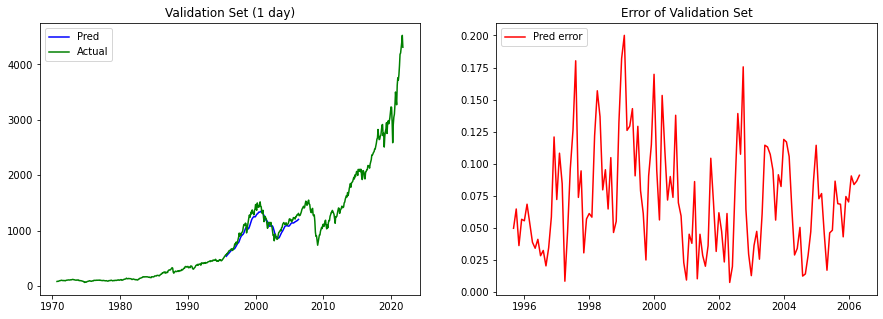

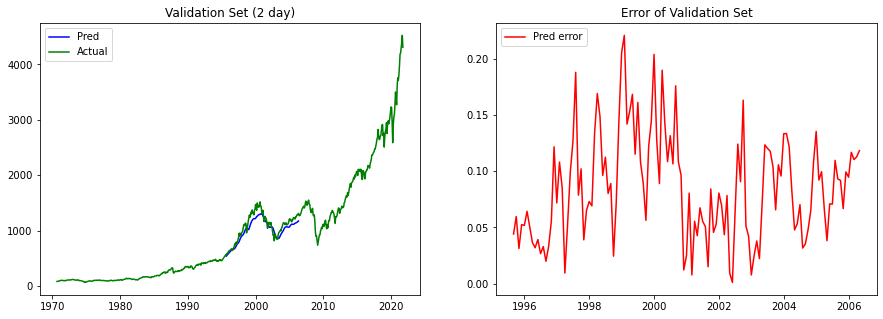

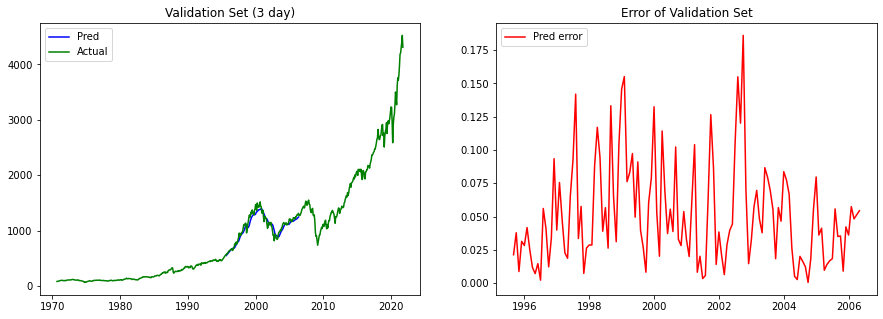

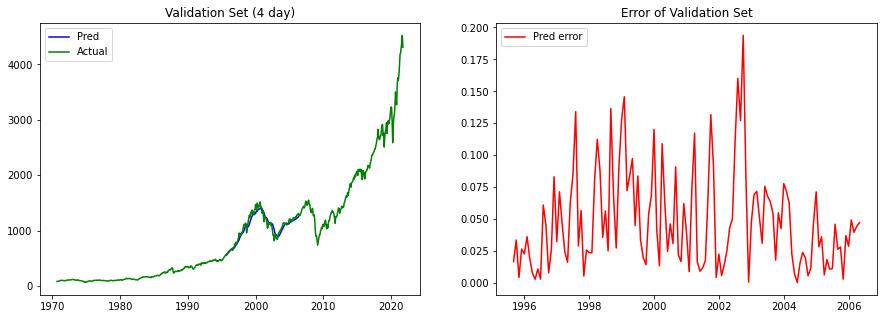

In [18]:
table = []

error = prediction_error(output_plt1, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (1 day)")
ax1.plot(date_v, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (2 day)")
ax1.plot(date_v, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (3 day)")
ax1.plot(date_v, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_validationplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Validation Set (4 day)")
ax1.plot(date_v, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Validation Set")
ax2.plot(date_v, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

In [19]:
xTensor = torch.from_numpy(X_test).float()
output, _ = RNNval(xTensor)

output_plt1 = output.detach().numpy()[:, 0]
output_plt1 = norm.inverse_transform(output_plt1.reshape(-1,1))

output_plt2 = output.detach().numpy()[:, 1]
output_plt2 = norm.inverse_transform(output_plt2.reshape(-1,1))

output_plt3 = output.detach().numpy()[:, 2]
output_plt3 = norm.inverse_transform(output_plt3.reshape(-1,1))

output_plt4 = output.detach().numpy()[:, 3]
output_plt4 = norm.inverse_transform(output_plt4.reshape(-1,1))

Y_testplt = norm.inverse_transform(Y_test[:, :, 0])

Mean   STD-dev  Skewness  Kurtosis
1 day  0.232106  0.183762  1.406811  1.785986
2 day  0.302523  0.240642  1.356482  1.543204
3 day  0.196912  0.174024  1.491366  1.960635
4 day  0.169635  0.145525  1.430876  1.790563

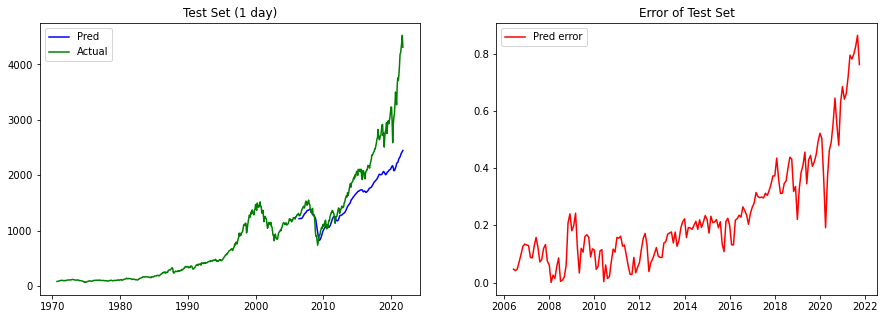

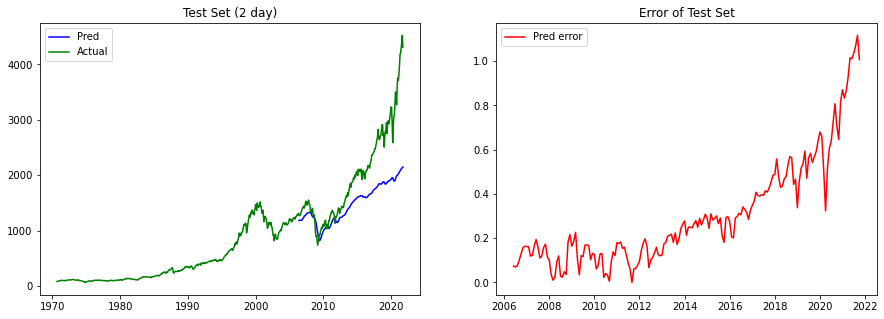

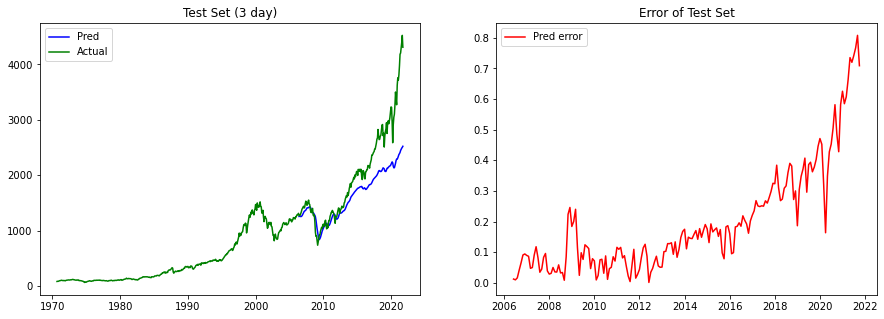

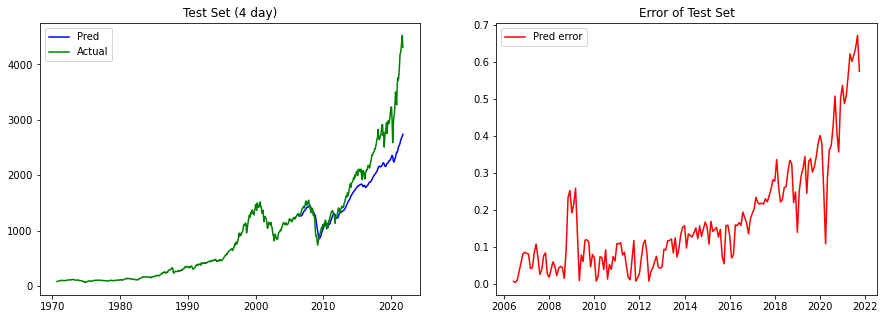

In [20]:
table = []

error = prediction_error(output_plt1, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp1 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp1 = np.array(temp1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (1 day)")
ax1.plot(date_t, output_plt1, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt2, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp2 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp2 = np.array(temp2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (2 day)")
ax1.plot(date_t, output_plt2, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt3, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp3 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp3 = np.array(temp3)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (3 day)")
ax1.plot(date_t, output_plt3, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")

error = prediction_error(output_plt4, Y_testplt)
error_dt = pd.DataFrame(data = error)
temp4 = [np.mean(error), np.std(error), error_dt.skew(axis=0).iloc[0], error_dt.kurtosis(axis=0).iloc[0]]
temp4 = np.array(temp4)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title("Test Set (4 day)")
ax1.plot(date_t, output_plt4, color = 'blue', label = 'Pred')
ax1.plot(dateAxis, Y_plt, color = 'green', label = 'Actual')
ax1.legend(loc="upper left")
ax2.set_title("Error of Test Set")
ax2.plot(date_t, error, color = 'red', label = 'Pred error')
ax2.legend(loc="upper left")


temp1 = np.expand_dims(temp1, axis=1)
temp2 = np.expand_dims(temp2, axis=1)
temp3 = np.expand_dims(temp3, axis=1)
temp4 = np.expand_dims(temp4, axis=1)
table = np.concatenate((temp1, temp2, temp3, temp4), axis=1)
ind = ['Mean', 'STD-dev', 'Skewness', 'Kurtosis']
col = ['1 day', '2 day', '3 day', '4 day']
stats=pd.DataFrame(table, columns=col, index=ind).T
stats

# Step 6

In [21]:
def predict(day_index):
    out_temp = np.concatenate( (Y_test[:, :, day_index], Y_test[:, :, day_index], Y_test[:, :, day_index]), axis = 1)
    target = norm.inverse_transform(out_temp)[:, [0]]
    error_res_all = []
    for sigma in stdev:
        noisy_data = NoisyTesting(X_test, sigma)
        inputs = Variable(torch.from_numpy(noisy_data).float())
        output, _ = RNNval(inputs)
        out_temp = np.concatenate((output.detach().numpy()[:, [day_index]], 
                                   output.detach().numpy()[:, [day_index]],  
                                   output.detach().numpy()[:, [day_index]]), axis=1)
        predicted_price = norm.inverse_transform(out_temp)[:, [0]]
        error = prediction_error(target, predicted_price)
        error_res_all.append(error.reshape(-1))
    return error_res_all

In [22]:
cmaps= ['red','purple', 'green', 'orange',  'yellow', 'pink', 'grey', 'brown', 'black','blue' ]
def FullGraphing(day):
    plt.figure(1, figsize=(15, 5))
    for i in range(len(stdev)): 
        #print(np.shape(date_test))
        #print(np.shape(error_res_all[i]))
        #print(np.shape(cmaps[i]))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  

    plt.xlabel('Date')
    plt.ylabel('Prediction error')
    plt.title('Prediction error with Different Noise Levels (next ' +day+ ' day)')
    plt.legend(loc="lower right") 
    plt.legend(loc="lower right")
    ax2=plt.twinx()
    ax2.set_xticks(ax2.get_xticks()[::20])

In [23]:
def IndividualGraphing(day):
    for i in range(len(stdev)): 
        plt.figure(1, figsize=(15, 5))
        plt.plot(np.squeeze(date_test), error_res_all[i], color=cmaps[i], lw=1, label = stdev[i], marker= 'o', linestyle='None')  
        plt.xlabel('Date')
        plt.ylabel('Prediction error')
        plt.title('Prediction error with Different Noise Levels (next '+day+' day)')
        plt.legend(loc="lower right")
        ax2=plt.twinx()
        ax2.set_xticks(ax2.get_xticks()[::20])
        plt.show()

In [24]:
print("NOISY")
stdev = [0,0.001, 0.002, 0.003, 0.005, 0.01, 0.02, 0.03, 0.05,0.1]

def NoisyTesting(dataset, sigma):
    noisy_data = np.ndarray(shape=dataset.shape, dtype=np.float32)
    #set seed for random numbers
    random.seed(1)
    for i in range(6):
        s = np.random.normal(0, sigma, 20)
        index = random.sample(list(range(180)), 20)
        noisy_data[i] = dataset[i]
        noisy_data[index, i, 0] = noisy_data[index, i, 0] + s
    return noisy_data

NOISY


0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.044848  0.044779  0.044757  0.044873  0.044785  0.045313   
01/09/2006  0.039817  0.039664  0.040294  0.040503  0.040024  0.041780   
01/10/2006  0.045146  0.045146  0.045146  0.045146  0.045146  0.045146   
01/11/2006  0.067515  0.067863  0.066925  0.067888  0.065348  0.070697   
01/12/2006  0.089307  0.089307  0.089307  0.089307  0.089307  0.089307   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.938536  0.983415  0.660806  0.277158  0.560039  0.561486   
01/09/2021  1.177896  0.356160  0.375456  0.375876  1.131715  0.572039   
01/10/2021  0.467433  0.470963  0.770369  0.338255  0.947428  0.271449   
01/11/2021  0.392014  0.385608  0.992698  0.353059  0.472144  0.322403   
01/12/2021  0.365054  1.023055  1.017644  0.404205  0.453173  0.449356   

               0.020     0.030     0.050     0.100  
01/08/2006  0.044346  0.047983  0.044355  0.053065  
01/09/2006  0.039292  0.055015  0.043737  0.049562  
01/10/2006  0.045146  0.045146  0.045146  0.045146  
01/11/2006  0.072697  0.061242  0.095291  0.070653  
01/12/2006  0.089307  0.089307  0.089307  0.089307  
...              ...       ...       ...       ...  
01/08/2021  0.566461  0.593492  0.981238  0.346247  
01/09/2021  0.868591  0.447513  0.978917  0.542888  
01/10/2021  0.596581  0.370932  1.263183  0.904289  
01/11/2021  0.385177  0.393852  0.462909  0.392509  
01/12/2021  1.279825  0.386421  1.274756  0.604283  

[185 rows x 10 columns]

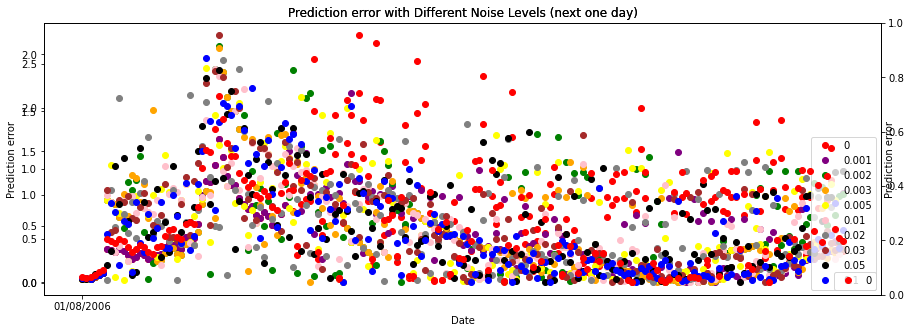

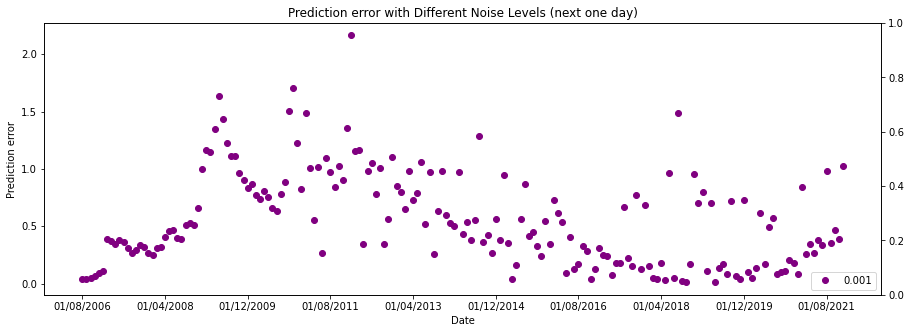

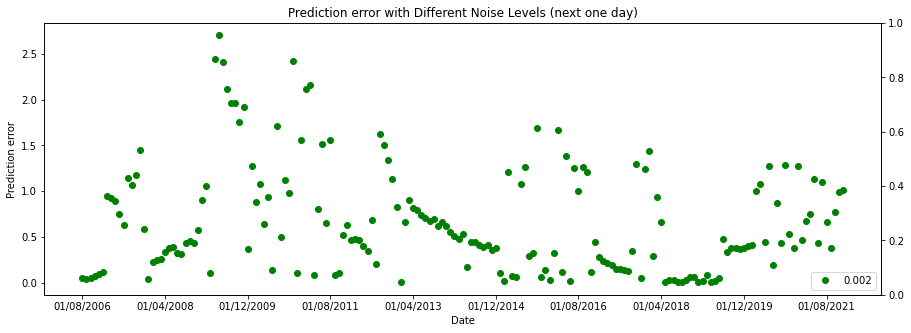

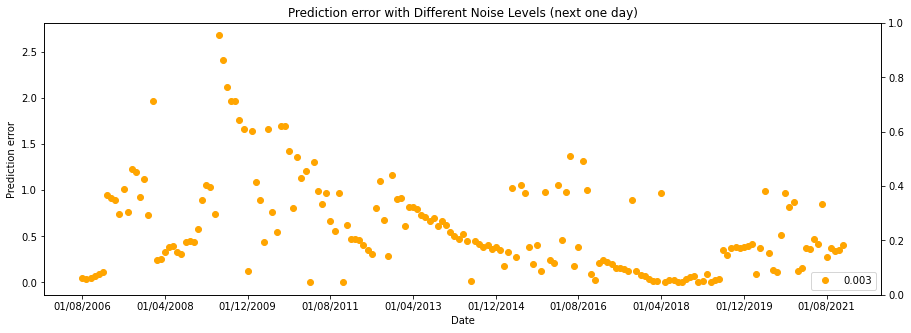

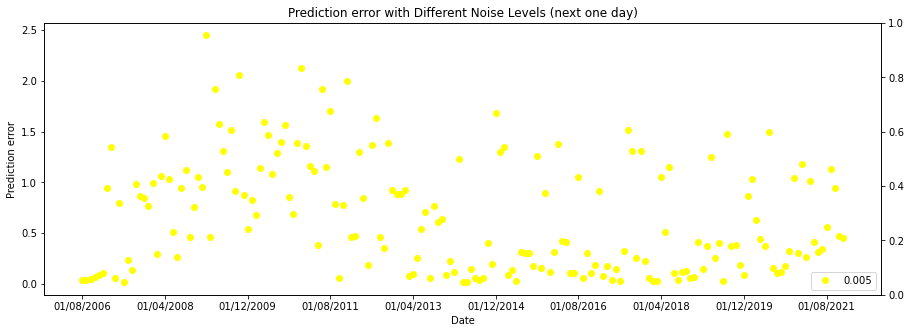

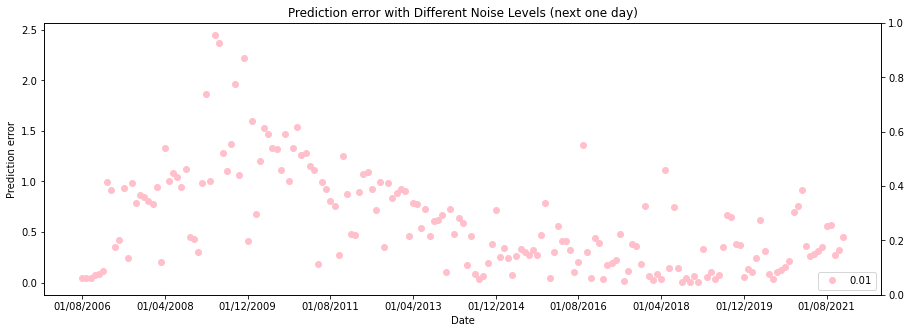

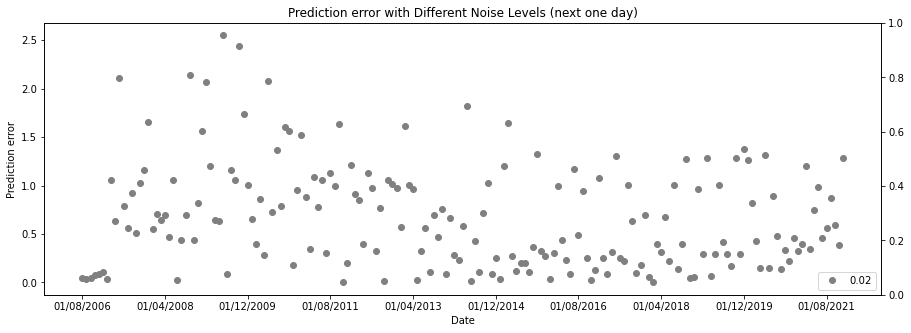

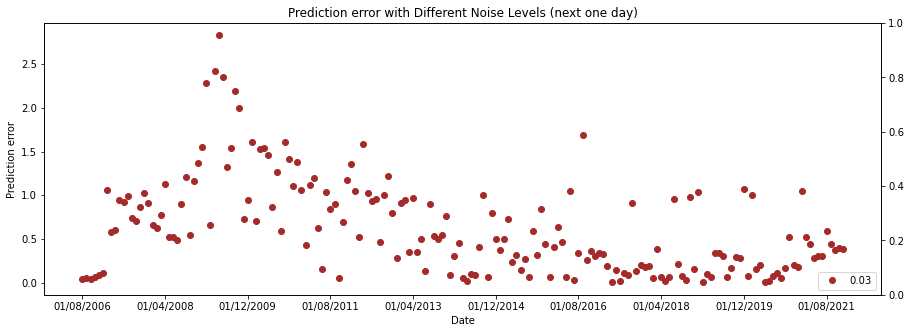

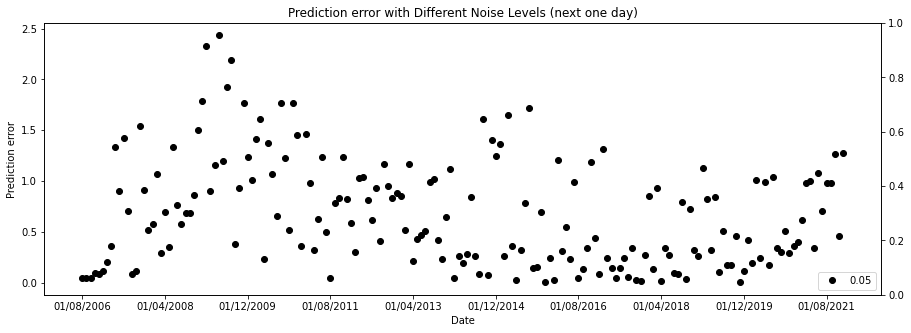

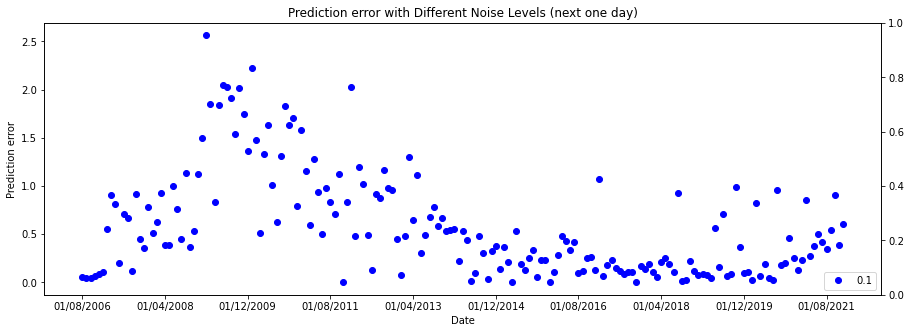

In [25]:
error_res_all=predict(0)

labels = date_test[:,0]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("one")
IndividualGraphing("one")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.069098  0.069011  0.069508  0.068983  0.070339  0.067680   
01/09/2006  0.069987  0.070044  0.070343  0.070589  0.069912  0.070019   
01/10/2006  0.089580  0.089580  0.089580  0.089580  0.089580  0.089580   
01/11/2006  0.112628  0.112745  0.112625  0.112558  0.113290  0.111249   
01/12/2006  0.140362  0.140362  0.140362  0.140362  0.140362  0.140362   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  1.268752  0.550984  1.268752  0.550984  1.268752  0.550984   
01/09/2021  0.296813  0.561079  0.296813  0.561079  0.296813  0.561079   
01/10/2021  1.712152  0.573444  1.712152  0.573444  1.712152  0.573444   
01/11/2021  1.554603  0.552016  1.554603  0.552016  1.554603  0.552016   
01/12/2021  0.527800  0.581038  0.527800  0.581038  0.527800  0.581038   

               0.020     0.030     0.050     0.100  
01/08/2006  0.067743  0.067658  0.071927  0.070921  
01/09/2006  0.065693  0.066430  0.059626  0.053173  
01/10/2006  0.089580  0.089580  0.089580  0.089580  
01/11/2006  0.112065  0.116029  0.110733  0.123644  
01/12/2006  0.140362  0.140362  0.140362  0.140362  
...              ...       ...       ...       ...  
01/08/2021  0.558672  0.550984  0.558672  0.550984  
01/09/2021  0.560977  0.561079  0.560977  0.561079  
01/10/2021  0.573333  0.573444  0.573333  0.573444  
01/11/2021  0.552077  0.552016  0.552077  0.552016  
01/12/2021  0.581087  0.581038  0.581087  0.581038  

[185 rows x 10 columns]

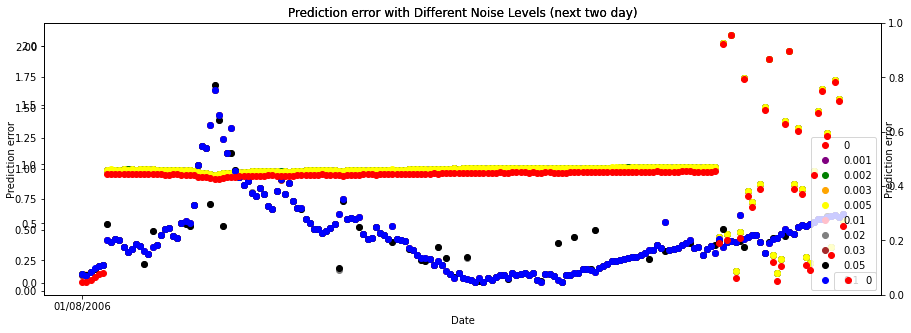

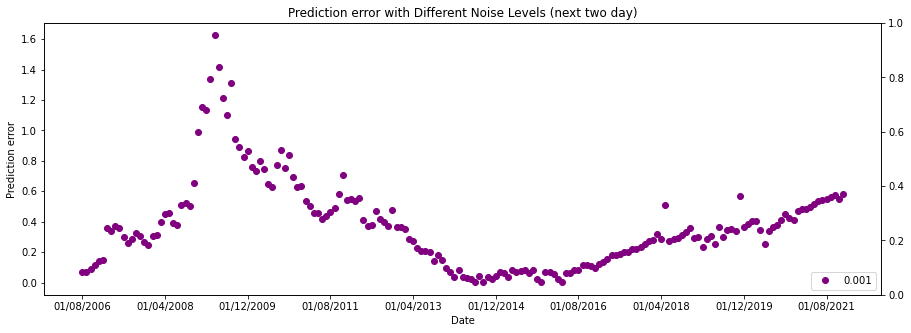

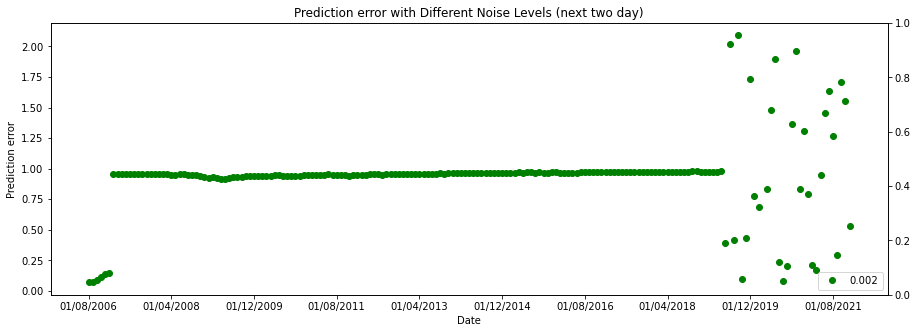

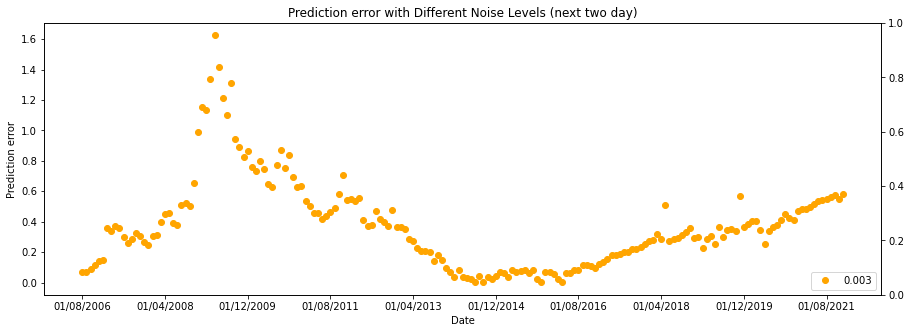

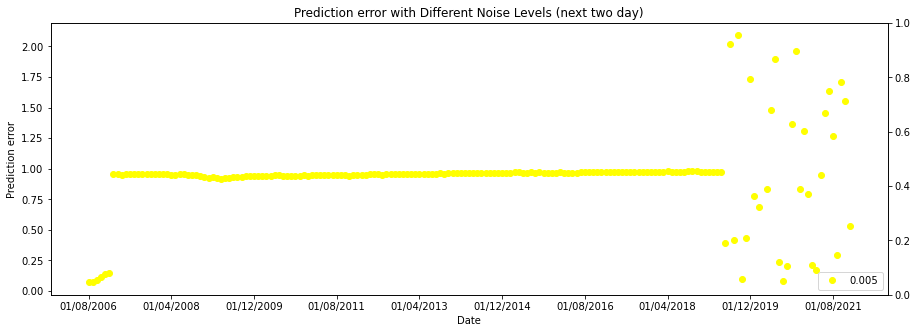

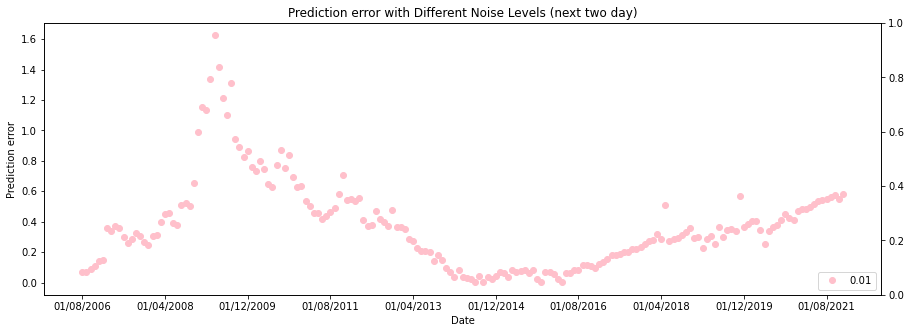

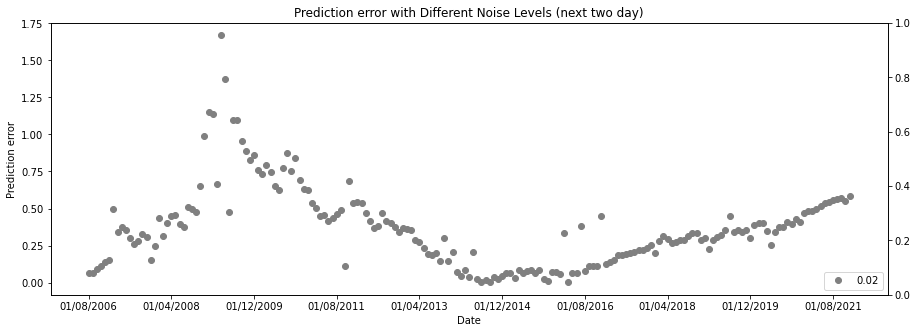

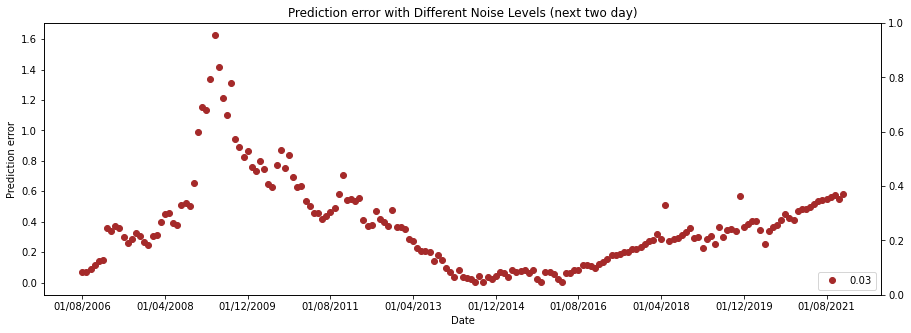

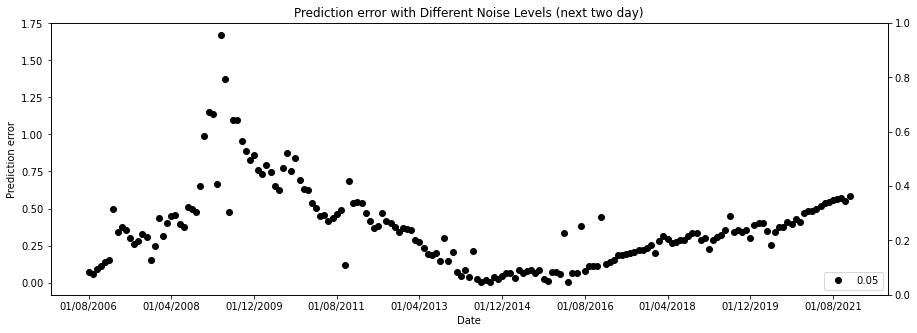

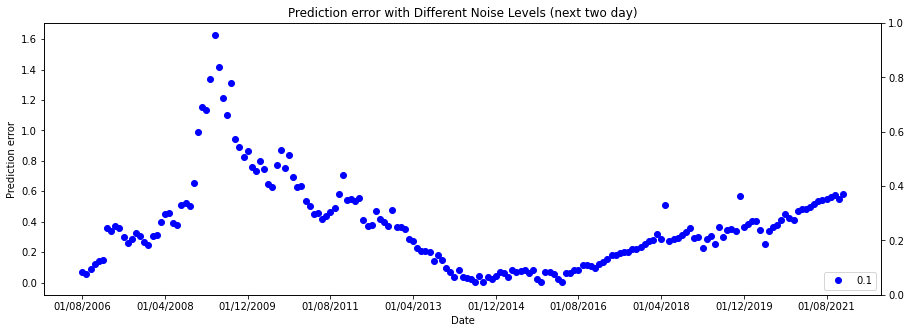

In [26]:
error_res_all=predict(1)

output.detach().numpy()[:,0:1]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("two")
IndividualGraphing("two")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.017168  0.017148  0.017194  0.017173  0.017264  0.017119   
01/09/2006  0.035084  0.035104  0.035261  0.035866  0.034563  0.035236   
01/10/2006  0.059446  0.059446  0.059446  0.059446  0.059446  0.059446   
01/11/2006  0.091378  0.091226  0.091732  0.090203  0.091514  0.089985   
01/12/2006  0.104474  0.104474  0.104474  0.104474  0.104474  0.104474   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.947773  0.314070  0.985047  0.314070  0.985047  0.314070   
01/09/2021  0.948158  0.329891  0.956982  0.329891  0.956982  0.329891   
01/10/2021  0.949339  0.296318  0.946411  0.296318  0.946411  0.296318   
01/11/2021  0.953723  0.341981  0.945713  0.341981  0.945713  0.341981   
01/12/2021  0.949502  0.336243  0.948182  0.336243  0.948182  0.336243   

               0.020     0.030     0.050     0.100  
01/08/2006  0.016368  0.016954  0.017149  0.016065  
01/09/2006  0.026415  0.029844  0.039434  0.071372  
01/10/2006  0.059446  0.059446  0.059446  0.059446  
01/11/2006  0.092813  0.084271  0.076529  0.124752  
01/12/2006  0.104474  0.104474  0.104474  0.104474  
...              ...       ...       ...       ...  
01/08/2021  0.985047  0.314070  0.985047  0.314070  
01/09/2021  0.956982  0.329891  0.956982  0.329891  
01/10/2021  0.946411  0.296318  0.946411  0.296318  
01/11/2021  0.945713  0.341981  0.945713  0.341981  
01/12/2021  0.948182  0.336243  0.948182  0.336243  

[185 rows x 10 columns]

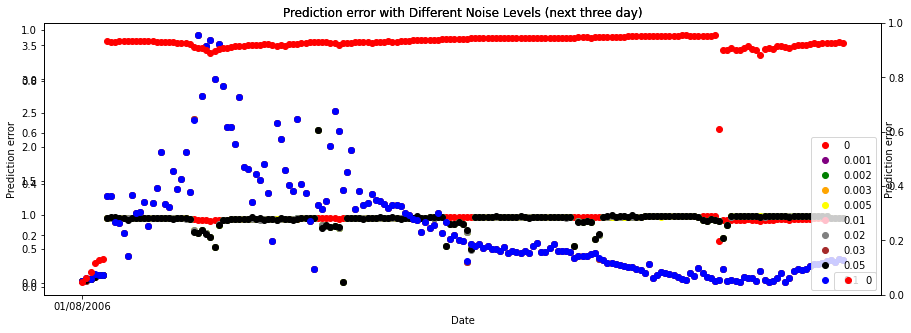

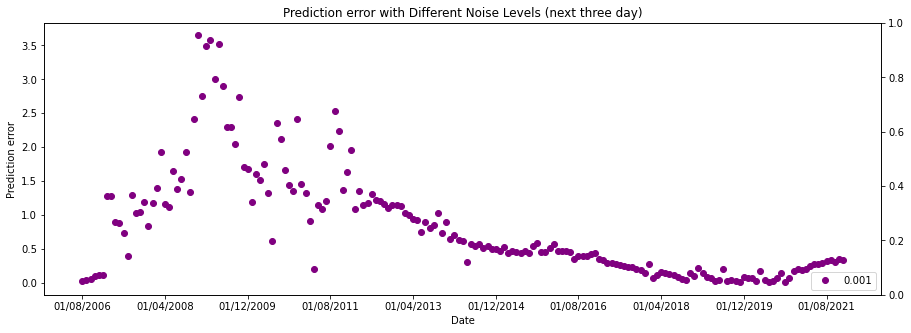

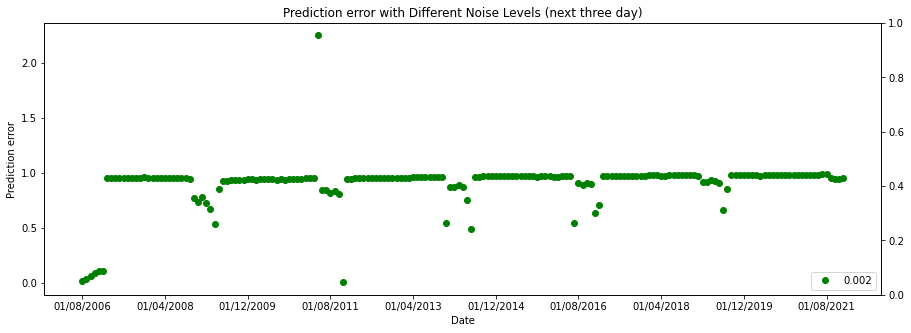

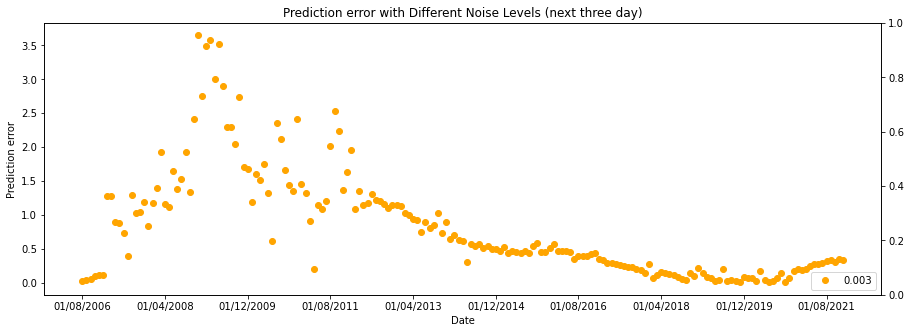

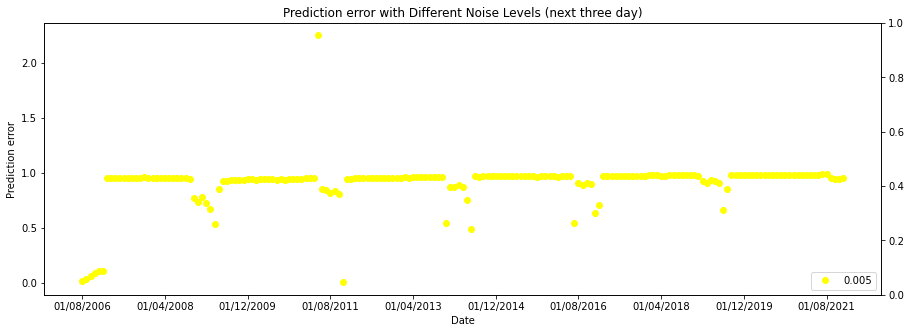

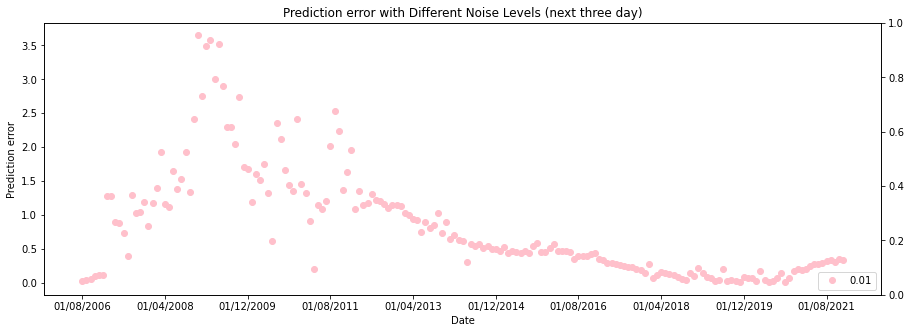

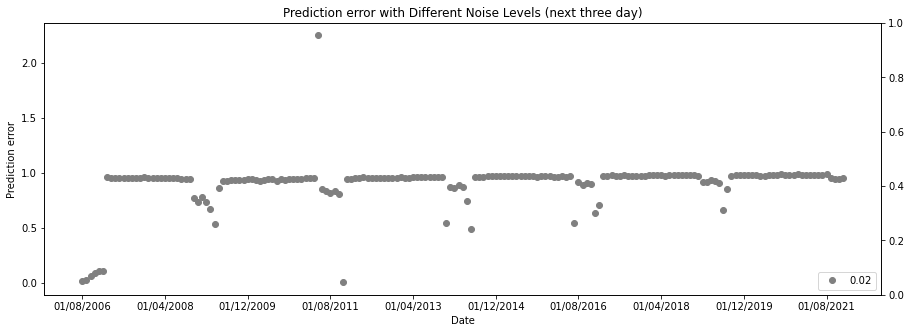

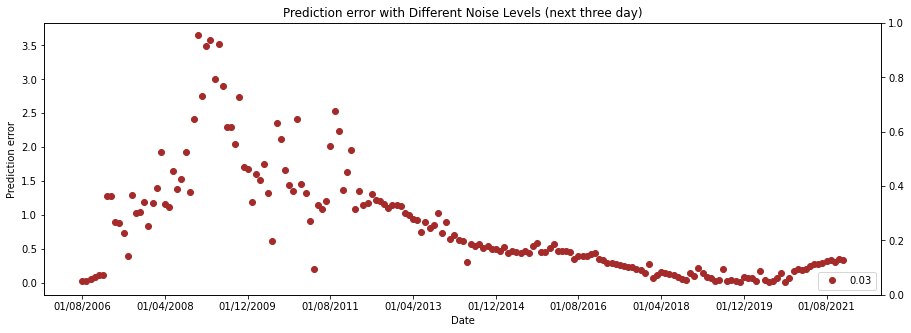

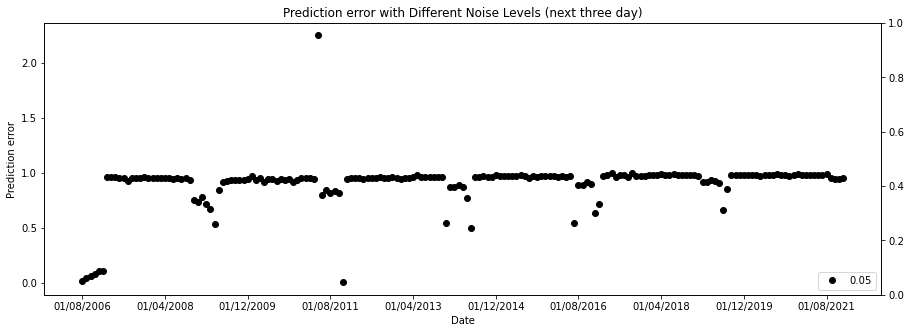

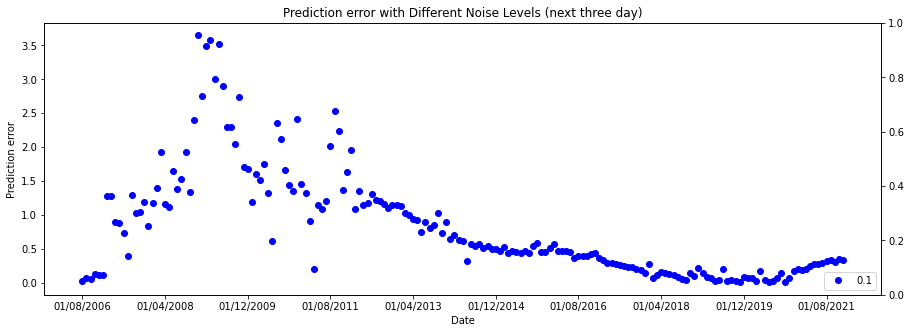

In [27]:
error_res_all=predict(2)

output.detach().numpy()[:,0:2]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("three")
IndividualGraphing("three")

0.000     0.001     0.002     0.003     0.005     0.010  \
01/08/2006  0.031540  0.031628  0.031599  0.031353  0.031023  0.031059   
01/09/2006  0.051962  0.051818  0.050078  0.051729  0.053055  0.051549   
01/10/2006  0.082507  0.082507  0.082507  0.082507  0.082507  0.082507   
01/11/2006  0.098794  0.098762  0.099576  0.098725  0.097412  0.100133   
01/12/2006  0.106945  0.106945  0.106945  0.106945  0.106945  0.106945   
...              ...       ...       ...       ...       ...       ...   
01/08/2021  0.950899  0.985491  0.950899  0.985491  0.950899  0.985491   
01/09/2021  0.951307  0.984766  0.951307  0.984766  0.951307  0.984766   
01/10/2021  0.954877  0.985751  0.954877  0.985751  0.954877  0.985751   
01/11/2021  0.956761  0.985631  0.956761  0.985631  0.956761  0.985631   
01/12/2021  0.954966  0.986232  0.954966  0.986232  0.954966  0.986232   

               0.020     0.030     0.050     0.100  
01/08/2006  0.032657  0.027633  0.031951  0.026730  
01/09/2006  0.050153  0.050208  0.053275  0.056103  
01/10/2006  0.082507  0.082507  0.082507  0.082507  
01/11/2006  0.103965  0.098802  0.106966  0.098088  
01/12/2006  0.106945  0.106945  0.106945  0.106945  
...              ...       ...       ...       ...  
01/08/2021  0.950899  0.985163  0.985491  0.985163  
01/09/2021  0.951307  0.984766  0.984766  0.984766  
01/10/2021  0.954877  0.986042  0.985751  0.986042  
01/11/2021  0.956761  0.985631  0.687722  0.985631  
01/12/2021  0.954966  0.986232  0.986232  0.986232  

[185 rows x 10 columns]

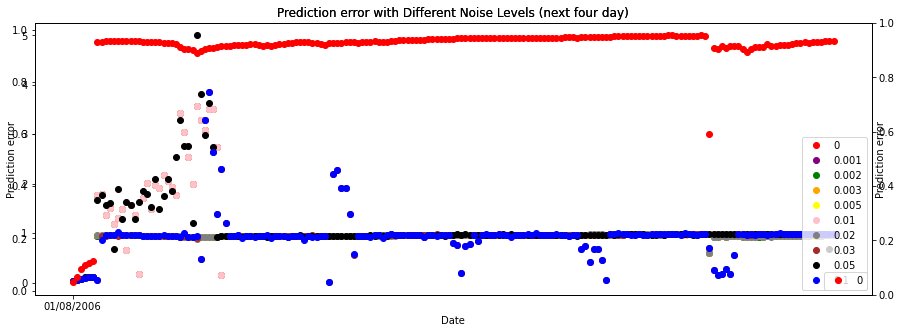

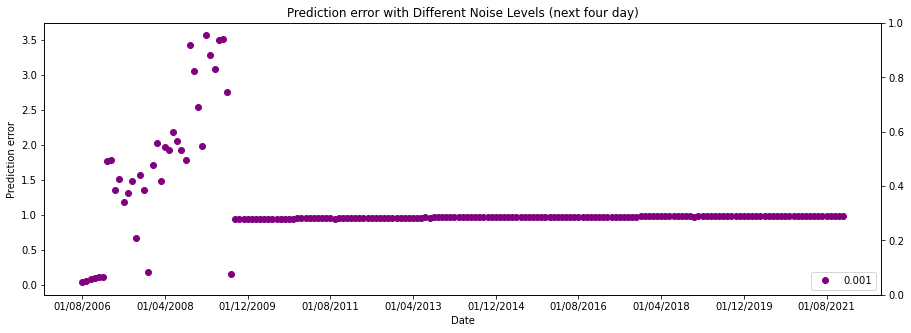

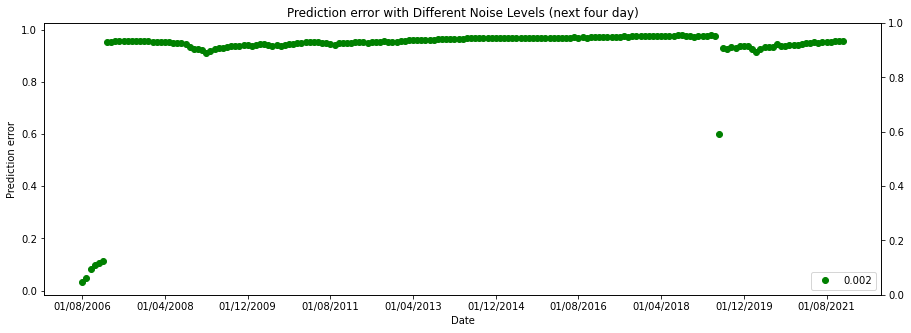

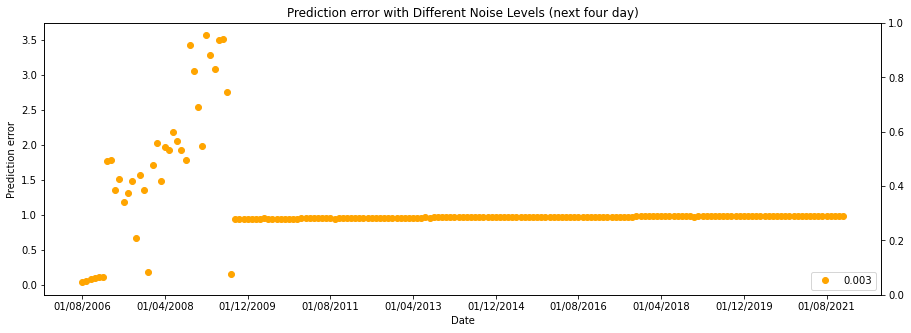

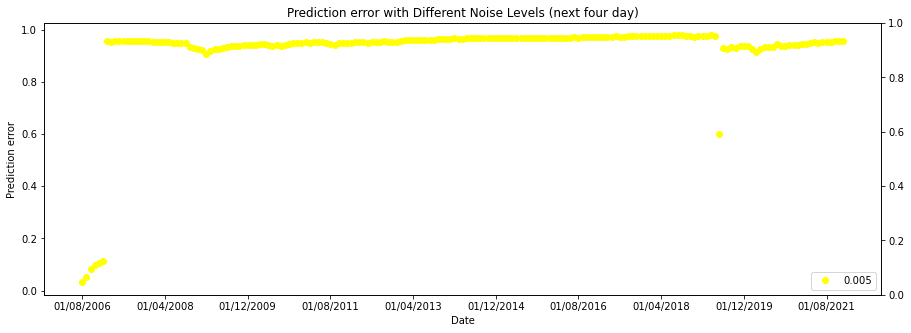

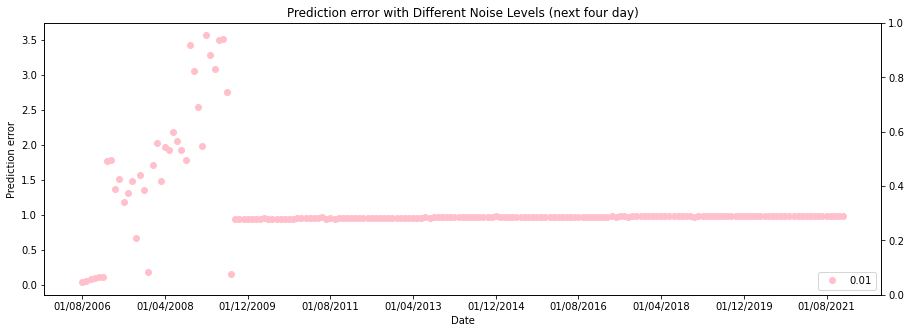

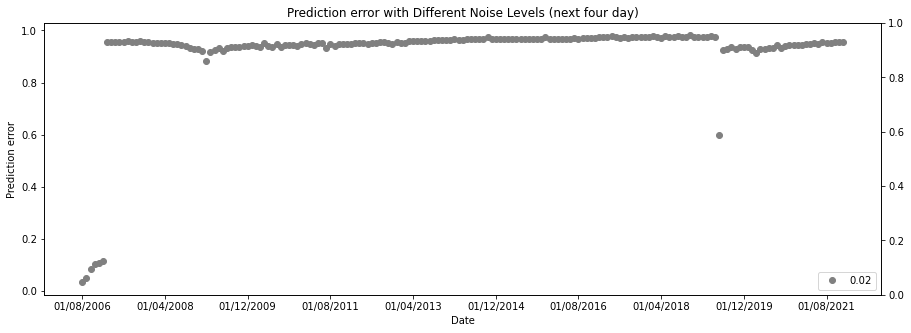

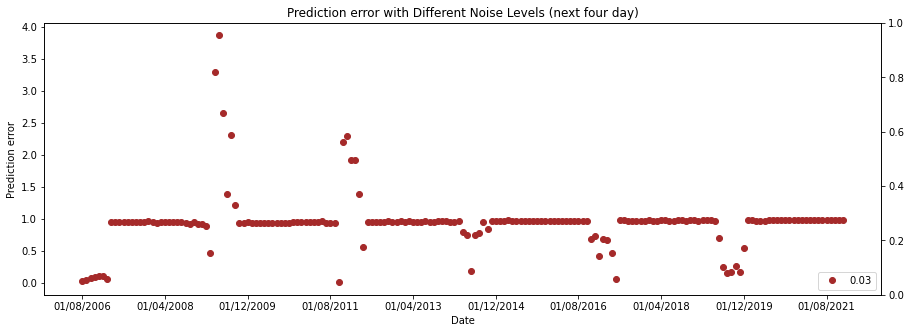

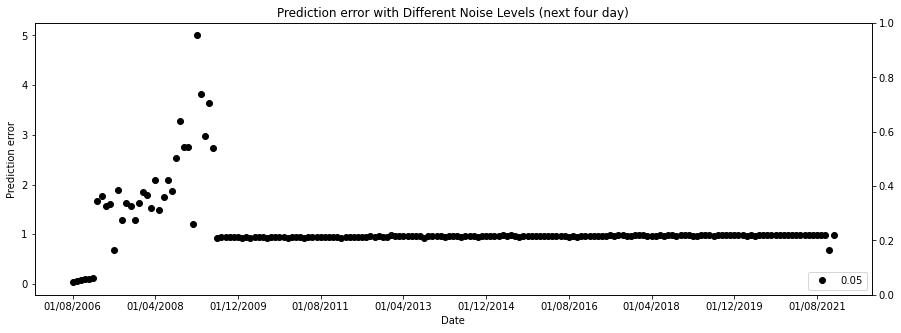

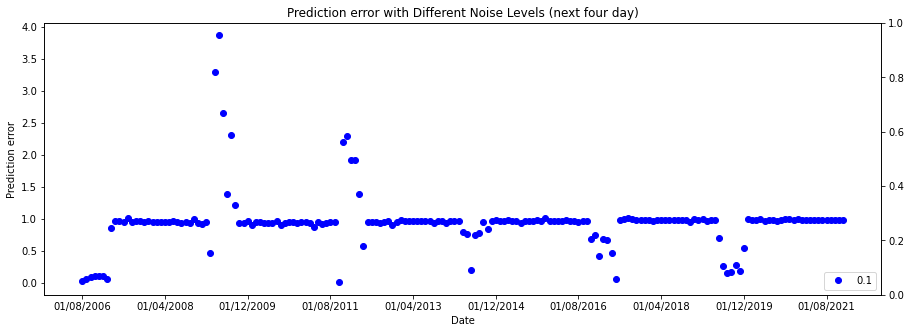

In [28]:
error_res_all=predict(3)

output.detach().numpy()[:,0:3]
df_error=pd.DataFrame(error_res_all, columns=labels, index=stdev).T
display(df_error)

FullGraphing("four")
IndividualGraphing("four")